# Composite Indicator

In [18]:
#importing libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

%load_ext extensions.skip

# defining a style
sns.set(style='darkgrid')
colors_arr = ['#1a96d0', '#fe9c39']

The extensions.skip extension is already loaded. To reload it, use:
  %reload_ext extensions.skip


In [128]:
# choose the spatial unit: neighborhood or hdu
spatial_unit = 'hdu'

spatial_area_label = 'hdu_id' if spatial_unit == 'hdu' else 'neighborhood'

## 1. Loading the data

This provided dataset is the one obtained after the data cleaning stage mentioned in the article *"A composite indicator of liveability based on sociodemographic and Uber quality service dimensions: a data-driven approach"*.

In [129]:
df = pd.read_csv("./data/uber_{}.csv".format(spatial_unit), index_col=0)

In [130]:
df[spatial_area_label] = df[spatial_area_label].astype(str)

### 1.1. Preparing the data

In [131]:
# adding new variables
if spatial_unit == 'neighborhood':
  df['car_crimes_rate'] = 100000*(df['car_theft'] + df['car_robbery'])/df['population']
  df['urban_services_ratio'] = 100000*(df['education_units'] + df['health_units'] + df['security_units'])/df['population']

In [132]:
numeric_cols = list(df.select_dtypes(['float64', 'int64']).columns)

# Selecting numeric columns and standardizing the variables
numerical_data = df[numeric_cols]
scaler = StandardScaler()
# data have to be standardized, once this is a requirement to run FA
numerical_data = scaler.fit_transform(numerical_data)

df_numerical = pd.DataFrame(numerical_data, columns = numeric_cols)
df_numerical.shape

(58, 15)

## 2. Composite Indicator of Liveability (CIL)

### 2.1. Factor Analysis (FA)

#### Checking suitability criteria


**CORRELATIONS**

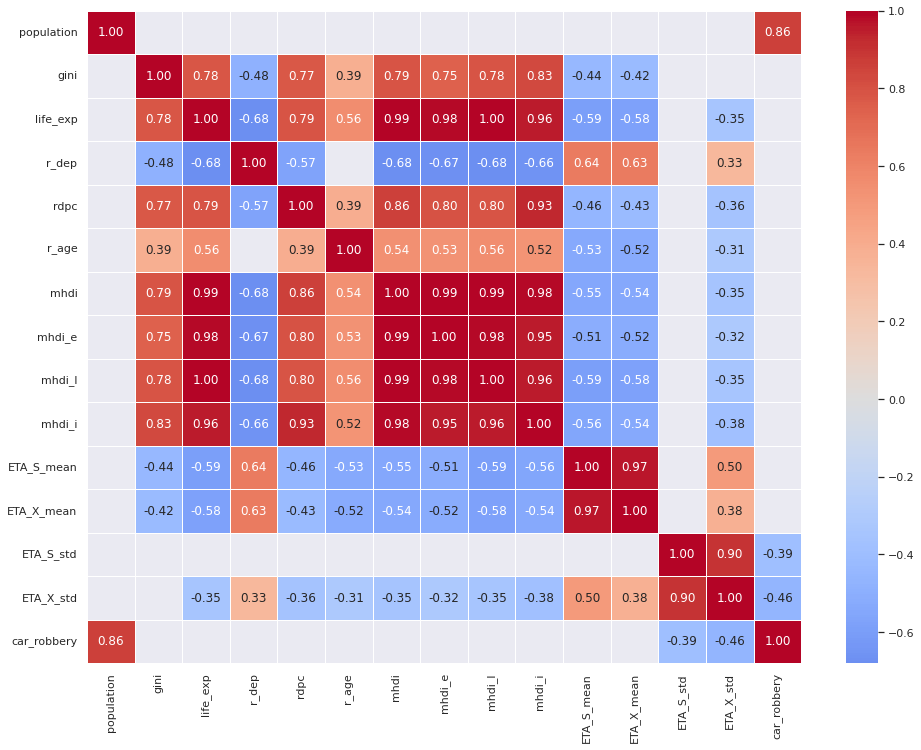

In [133]:
corr = df_numerical.corr()
fig, ax = plt.subplots(figsize=(16,12))

# Hiding the correlations that are smaller than 0.3
sns.heatmap(corr, mask = corr.abs() < 0.3, cmap="coolwarm", center=0, annot=True, fmt=".2f", linewidths=.5, ax=ax)
bottom, top = ax.get_ylim()

In [134]:
(corr.abs() < 0.3).sum().sum()/corr.shape[0]**2

0.3288888888888889

Initially, the Factor Analysis (FA) was undertaken considering neighborhood as unit of analysis. However, this dataset did not meet the suitability criteria for the FA implementation, mainly because its variables are mostly weakly correlated (about **57%** of the correlogram coefficients were less than 0.3 and more than **76%** were less than 0.5).  Consequently, it was not feasible to implement the indicator for this spatial aggregation level.

In the case of intra-neighborhood (HDU), three variables (population, car_robbery, ETA_S_std) with the highest amount of weak correlations had to be eliminated so that all the FA suitability criteria could be met.

In [135]:
# As the strong correlations were found only in the HDU dataset, we can skip the following steps for the neighborhood dataset
skip_cell = spatial_unit == 'neighborhood'

In [136]:
%%skip $skip_cell

df_numerical = df_numerical.drop(['population', 'car_robbery', 'ETA_S_std'], axis=1)

# checking the ratio of correlation values that are smaller than 0.3
corr = df_numerical.corr()
print((corr.abs() < 0.3).sum().sum()/corr.shape[0]**2)

0.027777777777777776


**STATISTICAL TESTS**

**Bartlett’s test** of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ factor analysis.

In [149]:
%%skip $skip_cell

def get_bartlett(df):
  return calculate_bartlett_sphericity(df_numerical)

chisquare, pvalue = get_bartlett(df_numerical)
print('The chi-square statistic is {:.4f}, with p-value {}'.format(chisquare, pvalue))

The chi-square statistic is 2082.2473, with p-value 0.0


**Kaiser-Meyer-Olkin (KMO) test** measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variables and ranges between 0 and 1. In general, a KMO < 0.6 is considered inadequate.

In [151]:
%%skip $skip_cell

def get_kmo(df):
  return calculate_kmo(df)

per_variable, total = get_kmo(df_numerical)
print('The KMO for each variable is ', per_variable)
print('The total KMO is {:.4f}'.format(total))

The KMO for each variable is  [0.80723918 0.7472363  0.95966472 0.92355548 0.9032584  0.69419184
 0.68321725 0.78947538 0.69591215 0.73883631 0.74133812 0.67185628]
The total KMO is 0.7618


/home/gisliany/anaconda3/envs/master-research/lib/python3.9/site-packages/factor_analyzer/utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


#### Factor Extraction using Principal Component Analysis (PCA)

In [157]:
def plot_eingvalues(df, eingvalues):
  fig = plt.figure(figsize=(10,7))

  plt.scatter(range(1, df.shape[1]+1), eingvalues)
  plt.plot(range(1, df.shape[1]+1), eingvalues)
  plt.plot(range(1, df.shape[1]+1), [1] * df.shape[1], '--', linewidth=1.5, color="red")
  
  plt.xlabel('Factors', fontsize=16)
  plt.ylabel('Eingvalues', fontsize=16)
  plt.tick_params(labelsize=14)

/home/gisliany/anaconda3/envs/master-research/lib/python3.9/site-packages/sklearn/utils/extmath.py:368: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


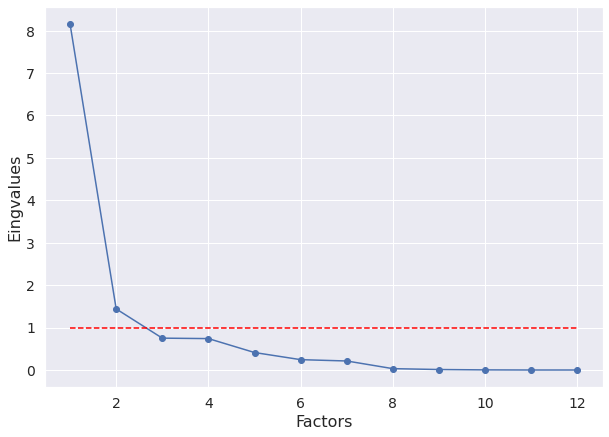

In [158]:
fa = FactorAnalyzer(n_factors=df_numerical.shape[1], method='principal', rotation=None)
fa.fit(df_numerical)

# check Eigenvalues
eingvalues, v = fa.get_eigenvalues()
plot_eingvalues(df_numerical, eingvalues)